# Time-evolution algorithms

We are going to implement the three algorithms compared in [Toward the first quantum simulation with quantum speedup](https://arxiv.org/pdf/1711.10980.pdf). These are the product formula, the truncated Taylor series and the qubitization approach.

To verify the implementation we are going to first implement the algorithm for a small 6 qubit system.

In [53]:
from tangelo.toolboxes.operators import QubitOperator
n_spins = 2
total_time = n_spins

hjs = [-0.7,0.5]

def get_spin_op(hjs):
    n_qubits = len(hjs)
    qu_op = QubitOperator()
    for j in range(n_qubits):
        qu_op += QubitOperator(f"X{j} X{(j+1)%n_qubits}")
        qu_op += QubitOperator(f"Y{j} Y{(j+1)%n_qubits}")
        qu_op += QubitOperator(f"Z{j} Z{(j+1)%n_qubits}")
        qu_op += hjs[j]*QubitOperator(f"Z{j}")
    return qu_op

In [54]:
from openfermion import get_sparse_operator
from scipy.linalg import expm
import numpy as np

def get_exact_evolution_operator(qu_op, time):
    sp_op = get_sparse_operator(qu_op).toarray()
    ev_op = expm(-1j*time*sp_op)
    return ev_op

ref_state = np.ones(2**n_spins)/np.sqrt(2**n_spins)

qu_op = get_spin_op(hjs)
ev_op = get_exact_evolution_operator(qu_op, total_time)
final_state = ev_op@ref_state
# Flip state from lsq_first to msq_first for comparison with qulacs
final_state = np.reshape(final_state, [2]*n_spins).transpose(list(reversed(range(n_spins)))).flatten()

In [55]:
from tangelo.linq import get_backend, Circuit, Gate

init_circ = Circuit([Gate("H", i) for i in range(n_spins)])
sim = get_backend("qulacs")

## Product formula

You can try different trotter orders and trotter steps to see if you can reproduce the results. The goal is an error less than 0.001, so an overlap of greater than 0.999.

In [56]:
from tangelo.toolboxes.ansatz_generator.ansatz_utils import trotterize
from tangelo.toolboxes.operators import count_qubits

def get_pf_circ(qu_op, total_time):
    n_trotter_steps = 4*round(count_qubits(qu_op)/2)
    pf_circ = init_circ + trotterize(qu_op, total_time, n_trotter_steps=n_trotter_steps, trotter_order=4)
    return pf_circ

pf_circ = get_pf_circ(qu_op, total_time)
f, pf_state = sim.simulate(pf_circ, return_statevector=True)



print("overlap", np.abs(np.vdot(final_state, pf_state)))
print("CNOT count", pf_circ.counts["CNOT"])
print("RZ counts", pf_circ.counts["RZ"])

overlap 0.999614098307875
CNOT count 240
RZ counts 200


## Truncated Taylor Series

In [60]:
from tangelo.toolboxes.circuits.lcu import get_truncated_taylor_series, get_truncated_taylor_series_qubits


def get_ts_circ(qu_op, total_time):
    ts_circ = get_truncated_taylor_series(qu_op, kmax=3, t=total_time)
    return ts_circ



ts_circ = init_circ + get_ts_circ(qu_op, total_time)
print(ts_circ.width, len(get_truncated_taylor_series_qubits(qu_op, kmax=3)))

n_ancilla = ts_circ.width - n_spins
measure_ops = Circuit([Gate("MEASURE", q) for q in range(n_spins, n_spins+n_ancilla)])
desired_measurement = "0"*n_ancilla
ts_circ += measure_ops

f, sv  = sim.simulate(ts_circ, return_statevector=True, desired_meas_result=desired_measurement)


15 15


In [61]:
ts_state = np.reshape(sv, (2**n_ancilla, 2**n_spins))[0, :]
print(n_ancilla)
print("overlap", np.abs(np.vdot(final_state, ts_state)))
print("gate counts", ts_circ.counts)
print("n_qubit counts", ts_circ.counts_n_qubit)

13
overlap 0.9999885290157179
gate counts {'H': 86, 'RY': 126, 'X': 5502, 'CRY': 3024, 'CNOT': 2268, 'CRZ': 1008, 'CPHASE': 945, 'CX': 420, 'CY': 378, 'CZ': 756, 'MEASURE': 13}
n_qubit counts {1: 5727, 2: 2772, 3: 2520, 5: 3465, 13: 42}


## Qubitization

Qubitization or Quantum Signal Processing is a technique that utilizes a block encoding followed by Rz rotations with angle $\psi_d$ of a specified value to reproduce a polynomial of the Hamiltonian. By utilizing the Jacobi-Anger representation of the exponential, we can represent time-evolution of a system using the circuit outlined in https://arxiv.org/abs/2002.11649 depicted below.

![QSP Circuit](QSP_Circuit.png "Quantum Signal Processing Circuit")

In [103]:
# We need to pyqsp installed to calculate the phase angles.
try:
    import pyqsp
except ModuleNotFoundError:
    %pip install pyqsp

In [64]:
from tangelo.toolboxes.circuits.qsp import get_qsp_hamiltonian_simulation_circuit

def get_qs_circ(qu_op, total_time):
    fac = count_qubits(qu_op)
    time_qs = total_time/fac
    qs_circ = get_qsp_hamiltonian_simulation_circuit(qu_op, time_qs, eps=1, n_attempts=100)
    return qs_circ*fac

qs_circ = init_circ + get_qs_circ(qu_op, total_time)
n_ancilla = qs_circ.width - n_spins
measure_ops = Circuit([Gate("MEASURE", q) for q in range(n_spins, n_spins+n_ancilla)])
desired_measurement = "0"*n_ancilla
qs_circ += measure_ops
f, sv  = sim.simulate(qs_circ, return_statevector=True, desired_meas_result=desired_measurement)

9.560046424292183
R=4
[PolyCosineTX] rescaling by 0.5.
9.560046424292183
R=4
[PolySineTX] rescaling by 0.5.


In [65]:
qs_state = np.reshape(sv, (2**n_ancilla, 2**n_spins))[0, :]
print(n_ancilla)
print("overlap", np.abs(np.vdot(final_state, qs_state)))
print("gate counts", qs_circ.counts)
print("n_qubit counts", qs_circ.counts_n_qubit)

6
overlap 0.9994100499065389
gate counts {'H': 26, 'RY': 3416, 'CNOT': 2912, 'X': 8152, 'CH': 56, 'CX': 1020, 'CRZ': 1232, 'CPHASE': 1190, 'CY': 476, 'CZ': 1190, 'RZ': 2, 'MEASURE': 6}
n_qubit counts {1: 11602, 2: 2912, 3: 574, 4: 532, 6: 4058}


### Reproducing the scaling

Once you are satisfied you have reasonable parameters, we can start attempting to reproduce the figures with. We will attempt to plot the T-complexity of various algorithms using the conversion of rotations outlined in https://arxiv.org/pdf/1403.2975.pdf

In [66]:
from cirq_ft import t_complexity
from tangelo.linq import translate_circuit

def total_t(circ: Circuit):
    t_complex = t_complexity(translate_circuit(circ, "cirq"))
    return t_complex.t + (10 + 4*np.log2(1/0.001)*t_complex.rotations)

ts_total_t = total_t(ts_circ)
qs_total_t = total_t(qs_circ)
pf_total_t = total_t(pf_circ)
print("Taylor Series T-complexity", ts_total_t)
print("Qubitization T-complexity", qs_total_t)
print("Product Formula T-complexity", pf_total_t)

Taylor Series T-complexity 8143675.873238931
Qubitization T-complexity 9475694.240302673
Product Formula T-complexity 7982.62742772967


In [75]:
ts_t_counts = []
qs_t_counts = []
pf_t_counts = []
spin_counts = [2, 4, 6]
for n in spin_counts:
    print(f"For n={n}")
    hjs = np.random.random(n)
    qu_op = get_spin_op(hjs)
    ts_t_counts += [total_t(get_ts_circ(qu_op, n))]
    qs_t_counts += [total_t(get_qs_circ(qu_op, n))]
    pf_t_counts += [total_t(get_pf_circ(qu_op, n))]

For n=2
8.3928788456481
R=4
[PolyCosineTX] rescaling by 0.5.
8.3928788456481
R=4
[PolySineTX] rescaling by 0.5.
For n=4
18.98048549554957
R=9
[PolyCosineTX] rescaling by 0.5.
18.98048549554957
R=9
[PolySineTX] rescaling by 0.5.
For n=6
28.075499511700574
R=14
[PolyCosineTX] rescaling by 0.5.
28.075499511700574
R=14
[PolySineTX] rescaling by 0.5.
Attempt 2 for the imaginary phases


Text(0, 0.5, 'T Gate Count')

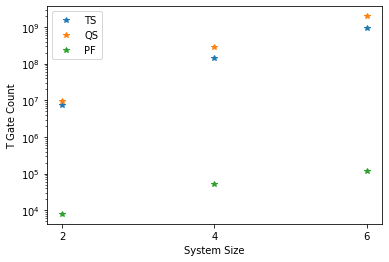

In [76]:
import matplotlib.pyplot as plt

plt.semilogy(spin_counts, ts_t_counts, "*")
plt.semilogy(spin_counts, qs_t_counts, "*")
plt.semilogy(spin_counts, pf_t_counts, "*")
plt.legend(["TS", "QS", "PF"])
plt.xticks(spin_counts[:3])
plt.xlabel("System Size")
plt.ylabel("T Gate Count")

In [101]:
from tangelo.toolboxes.circuits.qsp import get_qsp_hamiltonian_simulation_qubit_list
ts_qubit_counts = []
qs_qubit_counts = []
pf_qubit_counts = []
spin_sizes = list(range(5, 101, 5))
for n in spin_sizes:
    hjs = 2*np.random.random(n)-1
    qu_op = get_spin_op(hjs)
    ts_qubit_counts += [len(get_truncated_taylor_series_qubits(qu_op, 7))]
    qs_qubit_counts += [len(get_qsp_hamiltonian_simulation_qubit_list(qu_op))]
    pf_qubit_counts += [n]

Text(0, 0.5, '# qubits')

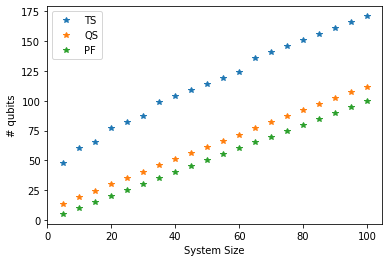

In [102]:
import matplotlib.pyplot as plt

plt.plot(spin_sizes, ts_qubit_counts, "*")
plt.plot(spin_sizes, qs_qubit_counts, "*")
plt.plot(spin_sizes, pf_qubit_counts, "*")
plt.legend(["TS", "QS", "PF"])
plt.xticks(list(range(0, 101, 20)))
plt.xlabel("System Size")
plt.ylabel("# qubits")